## Part2. 이미지 전처리 및 모델링



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 모델링에 사용할 최종 df를 로드합니다.

import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/project/df_final.csv', usecols=['category_id', 'thumbnail_link'])
df_Analysis = pd.read_csv('/content/drive/MyDrive/project/df_Analysis.csv').drop("Unnamed: 0", axis=1)

---
### 이번 프로젝트에서는 카테고리가 Entertainment인 썸네일을 학습할 것입니다.

---

In [ ]:
df_ent = df.query('category_id == "Entertainment"').reset_index(drop=True)
df_ent

,category_id,thumbnail_link
0,Entertainment,https://i.ytimg.com/vi/8d3toPkLJlg/default.jpg
1,Entertainment,https://i.ytimg.com/vi/XlscfyWNkLQ/default.jpg
2,Entertainment,https://i.ytimg.com/vi/X54cWd_cF4o/default.jpg
3,Entertainment,https://i.ytimg.com/vi/UPvnMR-3Xqo/default.jpg
4,Entertainment,https://i.ytimg.com/vi/ohf4Ut8DPV8/default.jpg
...,...,...
52924,Entertainment,https://i.ytimg.com/vi/iB5RmYZpKV4/default.jpg
52925,Entertainment,https://i.ytimg.com/vi/HPCG_5hRCdc/default.jpg
52926,Entertainment,https://i.ytimg.com/vi/rfCELGKzt1M/default.jpg
52927,Entertainment,https://i.ytimg.com/vi/Slz9KZWkPLU/default.jpg


### 시간 관계상 3000개의 이미지로 전처리 및 모델 구축

1. 이미지 다운로드
2. 이미지 크기 조정
3. 이미지 전처리
4. 차원 조정


In [ ]:
import requests
from PIL import Image
import os
from io import BytesIO

# 1. 이미지 다운로드

thumnbnail_list = list(df_ent.thumbnail_link[:5000])
series_thumbnail_links = thumnbnail_list

# 시리즈 저장 폴더 경로
save_folder = '/content/drive/MyDrive/project/Image/Ent'

# 시리즈 이미지 다운로드 및 저장
for i, thumbnail_link in enumerate(series_thumbnail_links):

    # 이미지 다운로드
    response = requests.get(thumbnail_link)
    
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content))

        # 시리즈 이미지 저장 경로
        save_path = os.path.join(save_folder, f"ent_{i+1}.jpg")

        # 이미지 저장
        image.save(save_path)


In [ ]:
# 2. 이미지 전처리

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

Ent_dir = '/content/drive/MyDrive/project/Image/Ent'

def preprocess_images(folder_path, grayscale=True):
    # 폴더 내 파일 이름들 가져오기
    file_names = os.listdir(folder_path)

    # 이미지 처리 결과를 저장할 리스트
    processed_images = []

    # 파일들에 대해 반복적으로 처리
    for file_name in file_names:
        # 이미지 파일 경로
        image_path = os.path.join(folder_path, file_name)

        # 이미지 열기
        with Image.open(image_path) as image:
            # 이미지 크기 조정
            resized_image = image.resize((32, 32))

            # 컬러 이미지를 흑백으로 변환
            # if grayscale:
                # resized_image = resized_image.convert("L")

            # 이미지 전처리
            normalized_image = np.array(resized_image) / 255.0

            # 차원 조정
            input_image = np.expand_dims(normalized_image, axis=0)

            # 처리된 이미지를 결과 리스트에 추가
            processed_images.append(input_image)

    # 결과 리스트를 NumPy 배열로 변환
    processed_images = np.array(processed_images)

    return processed_images

In [ ]:
Ent_images = preprocess_images(Ent_dir)

In [ ]:
Ent_images.shape

(3329, 1, 32, 32, 3)

In [ ]:
# reshape

Ent_images = Ent_images.reshape(3329, 32, 32, 3)

In [ ]:
# AutoEncoder Model 사용

import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Concatenate, Flatten, Lambda
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from keras.losses import binary_crossentropy, kullback_leibler_divergence
from keras import backend as K

def create_AE():
    input_img = Input(shape=(32, 32, 3))

    channels = 2
    x = input_img
    for i in range(4):
        channels *= 2
        input1 = Conv2D(channels, (3,3), activation='relu', padding='same')(x)
        input2 = Conv2D(channels, (2,2), activation='relu', padding='same')(x)
        x = Concatenate()([input1, input2])
        x = MaxPooling2D((2,2), padding='same')(x)

    x = Dense(channels)(x)

    for i in range(4):
        x = Conv2D(channels,(3,3), activation='relu', padding='same')(x)
        x = UpSampling2D((2,2))(x)

        channels //= 2
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return autoencoder

autoencoder = create_AE()
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_13 (Conv2D)             (None, 32, 32, 4)    112         ['input_2[0][0]']                
                                                                                                  
 conv2d_14 (Conv2D)             (None, 32, 32, 4)    52          ['input_2[0][0]']                
                                                                                                  
 concatenate_4 (Concatenate)    (None, 32, 32, 8)    0           ['conv2d_13[0][0]',              
                                                                  'conv2d_14[0][0]']        

In [ ]:
# 학습은 20000 epoch을 총 두 번 진행하였음

autoencoder.fit(Ent_images, Ent_images,
                epochs=20000,
                batch_size=128,
                shuffle=True)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
27/27 [==============================] - 0s 11ms/step - loss: 0.4781
Epoch 17502/20000
27/27 [==============================] - 0s 11ms/step - loss: 0.4781
Epoch 17503/20000
27/27 [==============================] - 0s 11ms/step - loss: 0.4781
Epoch 17504/20000
27/27 [==============================] - 0s 10ms/step - loss: 0.4781
Epoch 17505/20000
27/27 [==============================] - 0s 12ms/step - loss: 0.4781
Epoch 17506/20000
27/27 [==============================] - 0s 11ms/step - loss: 0.4781
Epoch 17507/20000
27/27 [==============================] - 0s 10ms/step - loss: 0.4781
Epoch 17508/20000
27/27 [==============================] - 0s 12ms/step - loss: 0.4781
Epoch 17509/20000
27/27 [==============================] - 0s 10ms/step - loss: 0.4781
Epoch 17510/20000
27/27 [==============================] - 0s 11ms/step - loss: 0.4781
Epoch 17511/20000
27/27 [==============================] - 0s 11ms/step - loss: 0.4781
Epoch 17512/20000
27/27 [

In [ ]:
cols = 25
idx = np.random.randint(Ent_images.shape[0], size=cols)
sample = Ent_images[idx]
decoded_imgs = autoencoder.predict(sample)
decoded_imgs.shape
sample.shape

1/1 [==============================] - 0s 20ms/step


(25, 32, 32, 3)

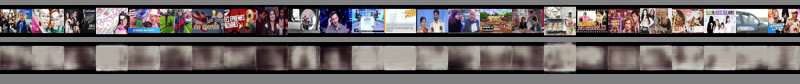

In [ ]:
# 생성된 이미지 시각화

from keras.layers import Reshape, Concatenate, Flatten, Lambda, Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from IPython.display import Image, display
from io import BytesIO
import PIL

def decode_img(tile, factor=1.0):
    tile = np.clip(tile * 255, 0, 255).astype('uint8')  # 이미지를 정수형으로 변환
    return PIL.Image.fromarray(tile, mode='RGB')
    

overview = PIL.Image.new('RGB', (cols * 32, 64 + 20), (128, 128, 128))
for idx in range(cols):
    overview.paste(decode_img(sample[idx]), (idx * 32, 5))
    overview.paste(decode_img(decoded_imgs[idx]), (idx * 32, 42))
f = BytesIO()
overview.save(f, 'png')
display(Image(data=f.getvalue()))

모델 저장

In [ ]:
autoencoder.save('/content/drive/MyDrive/project/autoencoder_final.h5')